In [1]:
import catboost as cb
from sklearn.metrics import mean_squared_error
import optuna

def objective(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "loss_function": "RMSE",  # Assuming regression, you might need to change this if you're doing classification
        "bootstrap_type": "Bernoulli",  # Using Bernoulli to handle the sample_weight
        "silent": True
    }

    # Compute the sample weights
    sample_weights = compute_sample_weight(
        class_weight='balanced',
        y=y_train
    )

    model = cb.CatBoostRegressor(**params)
    model.fit(X_train, y_train, sample_weight=sample_weights, eval_set=[(X_test, y_test)])
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    return rmse

In [4]:
from importlib import reload
import pandas as pd
import numpy as np
import xgboost as xgb
import scikitplot as skplt
import seaborn as sns
import matplotlib.pyplot as plt
from utility import load_data, plot_confusion_matrix, plot_average_f1_scores, train_model, get_classification_details, get_hard_disk_path, show_samples, plot_features_importance, visualize_correlation, get_shap
import utility
reload(utility)
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

X, y, unique_labels, label_mapping, data = load_data(get_hard_disk_path())
# Use a list for labels to ensure consistent order
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Print the optimization results
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print(f"{key}: {value}")

[I 2023-11-03 13:38:56,447] A new study created in memory with name: no-name-f5112523-ceaf-4bf3-a1b7-e93034541013


Successfully loaded data from E:/data_for_seg/


[I 2023-11-03 13:38:58,009] Trial 0 finished with value: 0.8979595764238718 and parameters: {'learning_rate': 0.029896892789395516, 'depth': 6, 'subsample': 0.3912681678338472, 'colsample_bylevel': 0.14443841433038485, 'min_data_in_leaf': 53}. Best is trial 0 with value: 0.8979595764238718.
[I 2023-11-03 13:38:58,829] Trial 1 finished with value: 0.8808647695836226 and parameters: {'learning_rate': 0.0567049654784317, 'depth': 4, 'subsample': 0.4424103404796541, 'colsample_bylevel': 0.1782482509477774, 'min_data_in_leaf': 32}. Best is trial 1 with value: 0.8808647695836226.
[I 2023-11-03 13:38:59,356] Trial 2 finished with value: 1.2035231274257563 and parameters: {'learning_rate': 0.005062644330010929, 'depth': 2, 'subsample': 0.7049558022839879, 'colsample_bylevel': 0.2622434902201671, 'min_data_in_leaf': 52}. Best is trial 1 with value: 0.8808647695836226.
[I 2023-11-03 13:39:01,921] Trial 3 finished with value: 0.8217702771816016 and parameters: {'learning_rate': 0.0343821173403370

Number of finished trials:  100
Best trial:
Value:  0.7198605136405173
Params: 
learning_rate: 0.03514033339475594
depth: 4
subsample: 0.6983280497870886
colsample_bylevel: 0.4327452011540816
min_data_in_leaf: 12


Successfully loaded data from E:/data_for_seg/


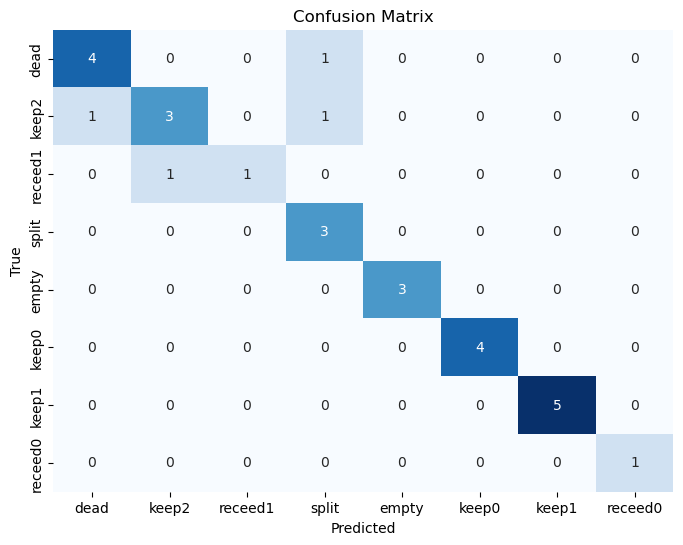

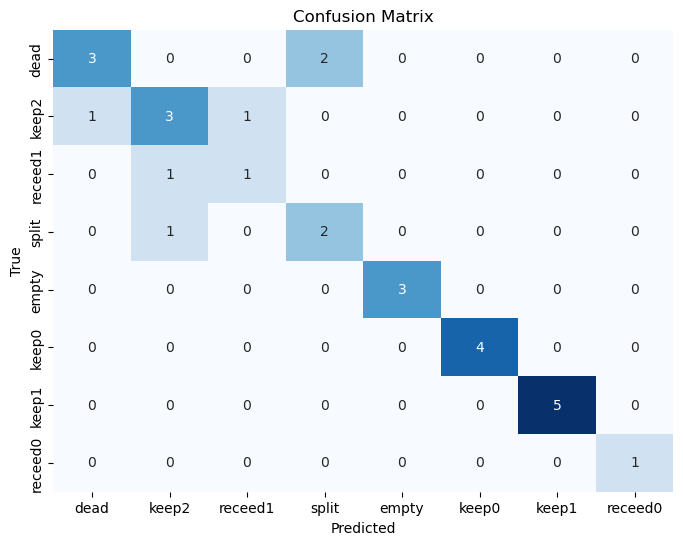

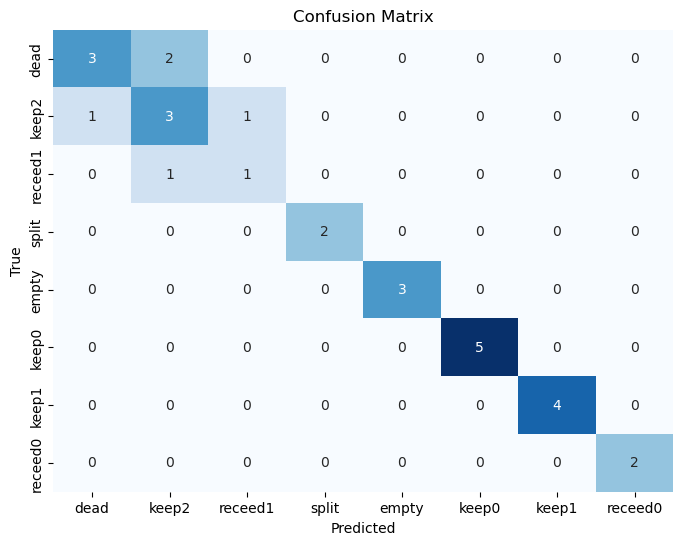

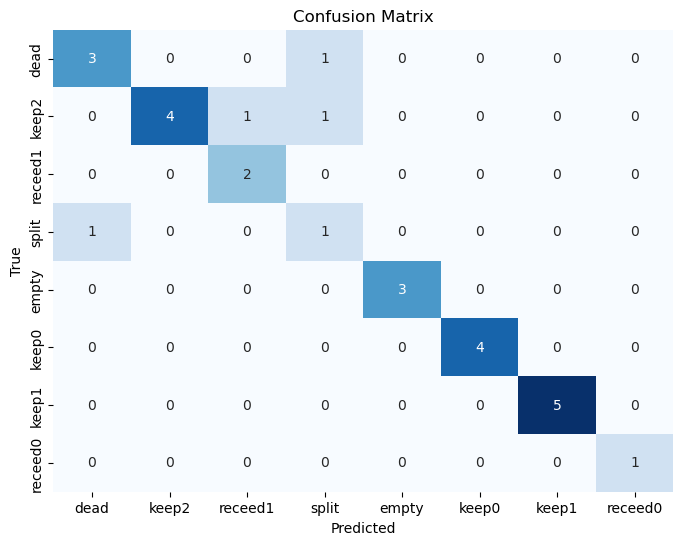

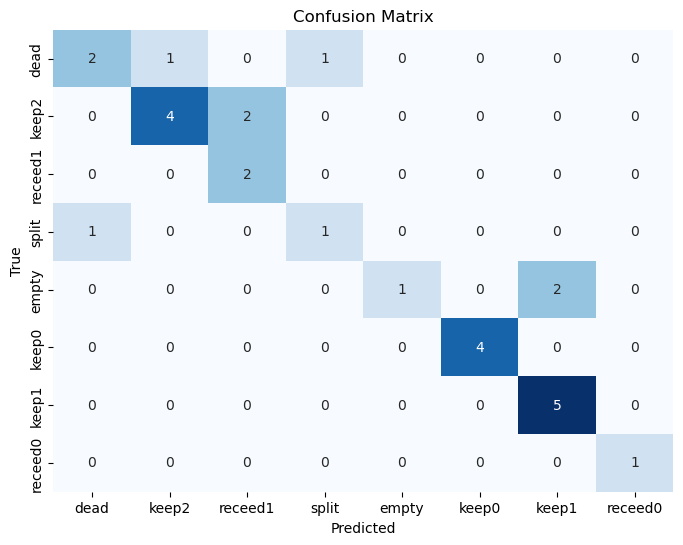

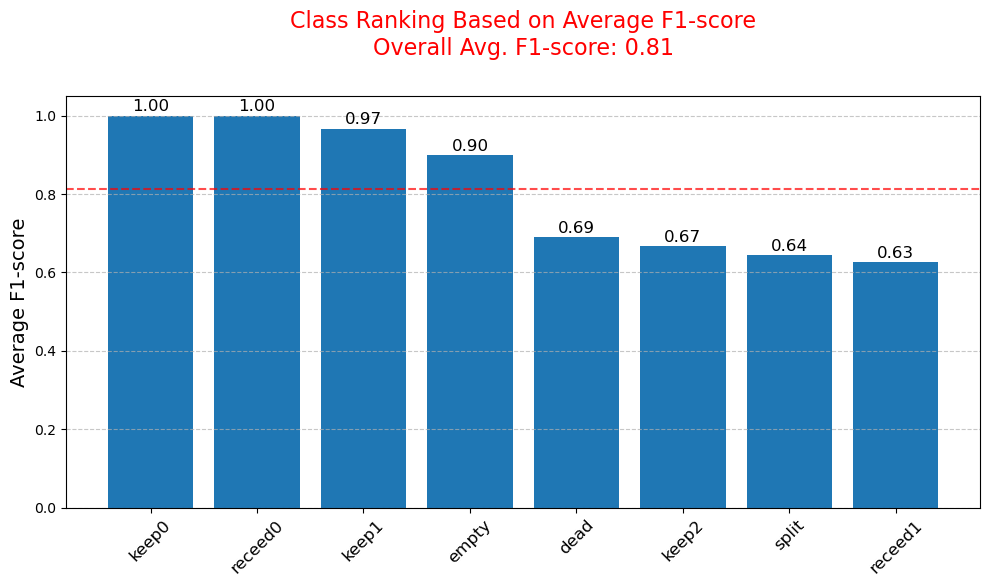

In [5]:
from utility import load_data, plot_confusion_matrix, plot_average_f1_scores, train_model, get_classification_details, get_hard_disk_path, show_samples, plot_features_importance, visualize_correlation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

random_state = 42

X, y, unique_labels, label_mapping, data = load_data(get_hard_disk_path())
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
fold_results = []
cumulative_f1_scores = {label: 0 for label in unique_labels}

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    classifier = train_model(X_train, y_train, unique_labels, "Catboost")
    y_pred = classifier.predict(X_test)
    plot_confusion_matrix(y_test, y_pred, unique_labels)
    #wellclassified_samples, misclassified_samples = get_classification_details(y_test, y_pred, data)
    #show_samples(get_hard_disk_path(), samples=wellclassified_samples, title="Correctly classified")
    #show_samples(get_hard_disk_path(), samples=misclassified_samples, title="Misclassified")

    # Additional operations you had for misclassified and wellclassified samples go here...

    f1_scores_per_class = f1_score(y_test, y_pred, average=None)
    for idx, label in enumerate(unique_labels):
        cumulative_f1_scores[label] += f1_scores_per_class[idx]

average_f1_scores = {label: score/5 for label, score in cumulative_f1_scores.items()} 
ranked_labels = sorted(average_f1_scores, key=average_f1_scores.get, reverse=True)
plot_average_f1_scores(ranked_labels, average_f1_scores)

Successfully loaded data from D:/data_for_seg/


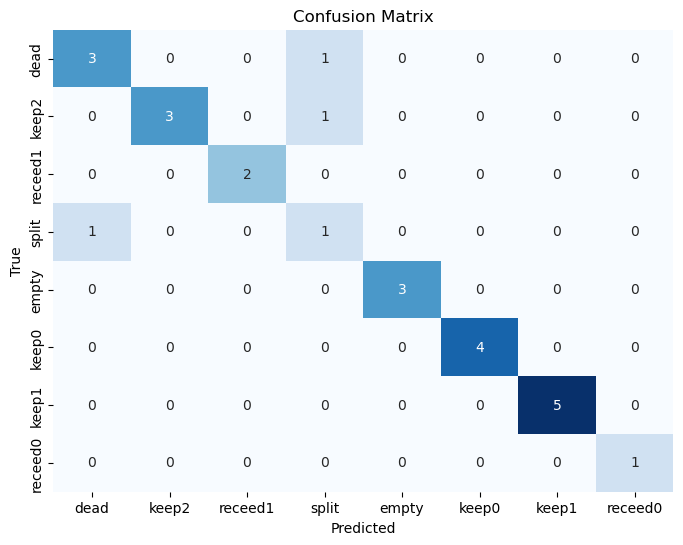

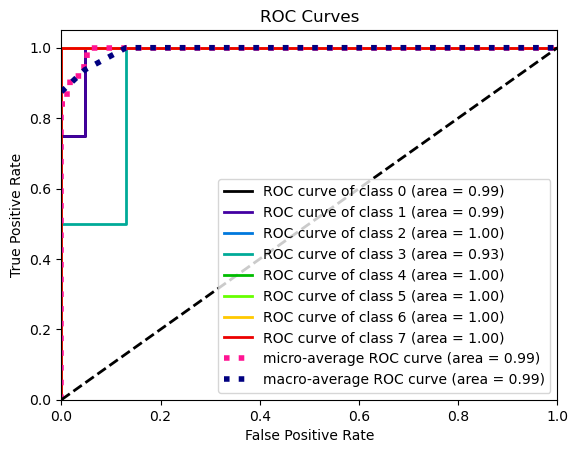

<Figure size 800x600 with 0 Axes>

[[6]
 [5]
 [5]
 [0]
 [4]
 [5]
 [2]
 [0]
 [2]
 [1]
 [7]
 [0]
 [3]
 [6]
 [3]
 [1]
 [5]
 [6]
 [6]
 [6]
 [4]
 [3]
 [1]
 [4]
 [0]]
Successfully loaded data from D:/data_for_seg/


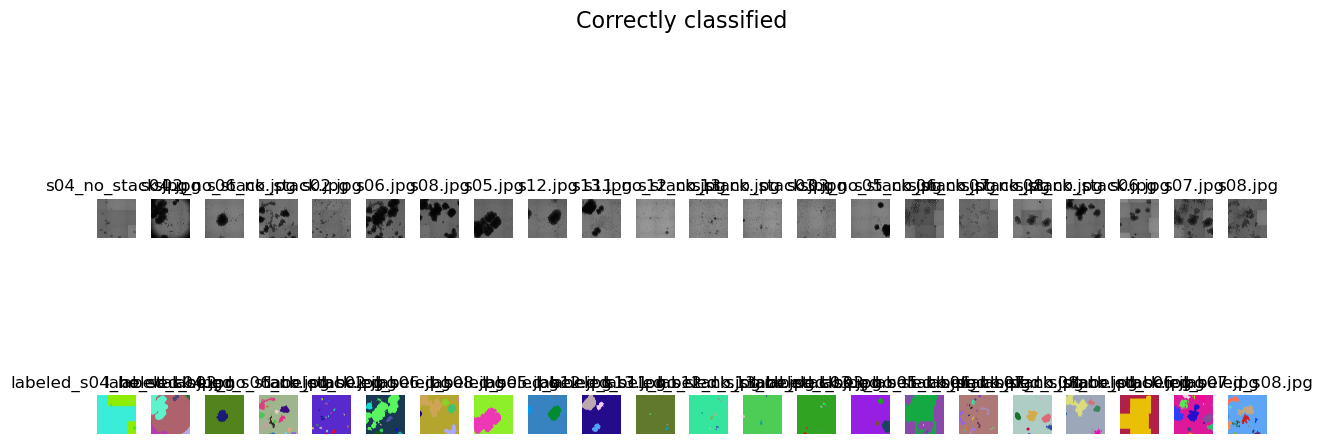

Successfully loaded data from D:/data_for_seg/


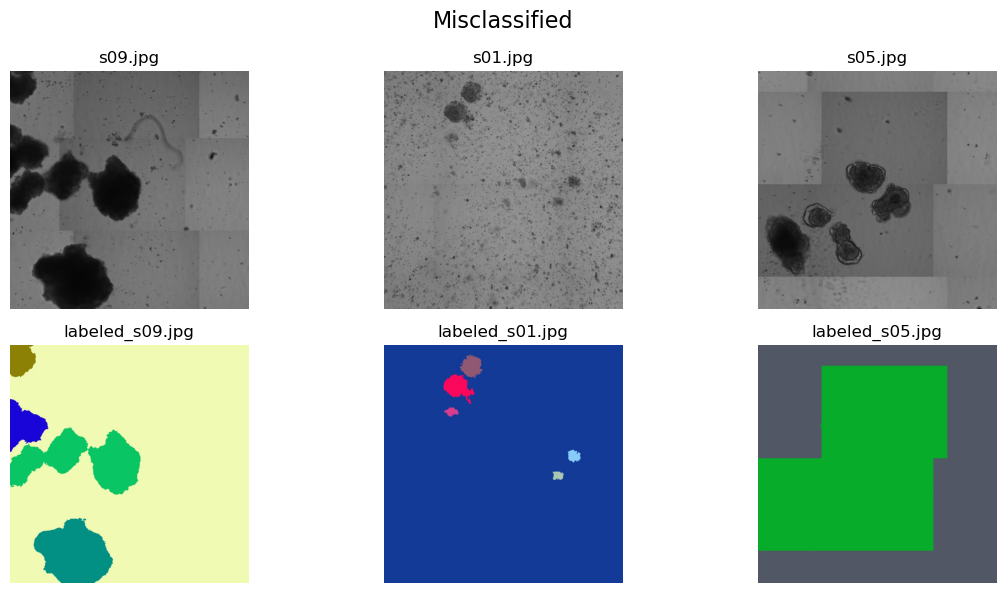

Misclassified Samples (Random State: 30):
7      dead - s09.jpg
14     dead - s01.jpg
21    keep2 - s05.jpg
dtype: object


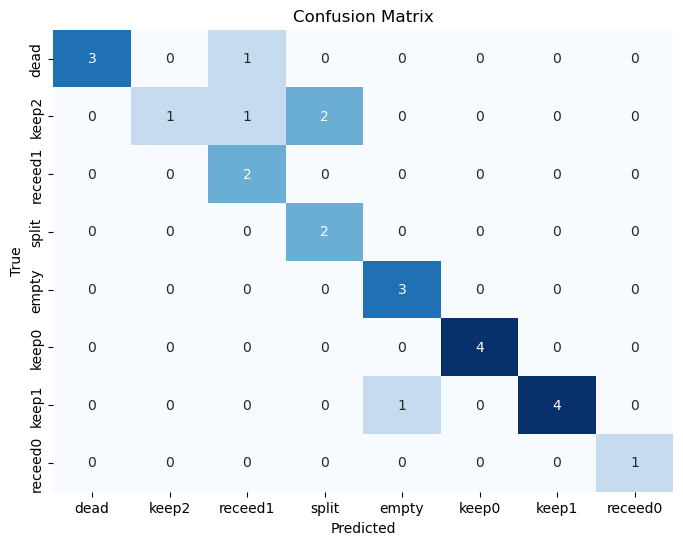

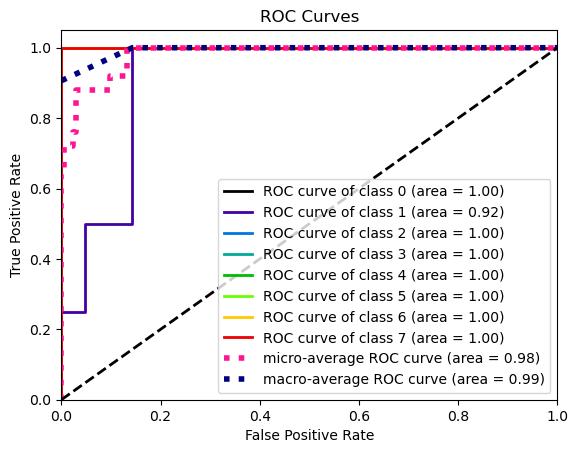

<Figure size 800x600 with 0 Axes>

[[4]
 [6]
 [3]
 [5]
 [2]
 [7]
 [2]
 [4]
 [6]
 [3]
 [5]
 [5]
 [4]
 [0]
 [4]
 [2]
 [3]
 [3]
 [1]
 [6]
 [6]
 [0]
 [0]
 [2]
 [5]]
Successfully loaded data from D:/data_for_seg/


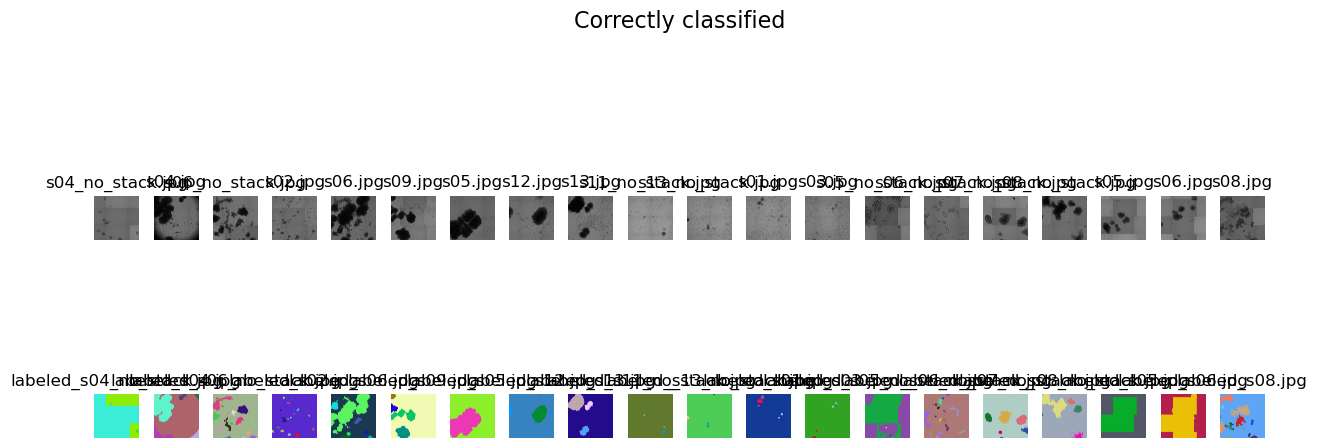

Successfully loaded data from D:/data_for_seg/


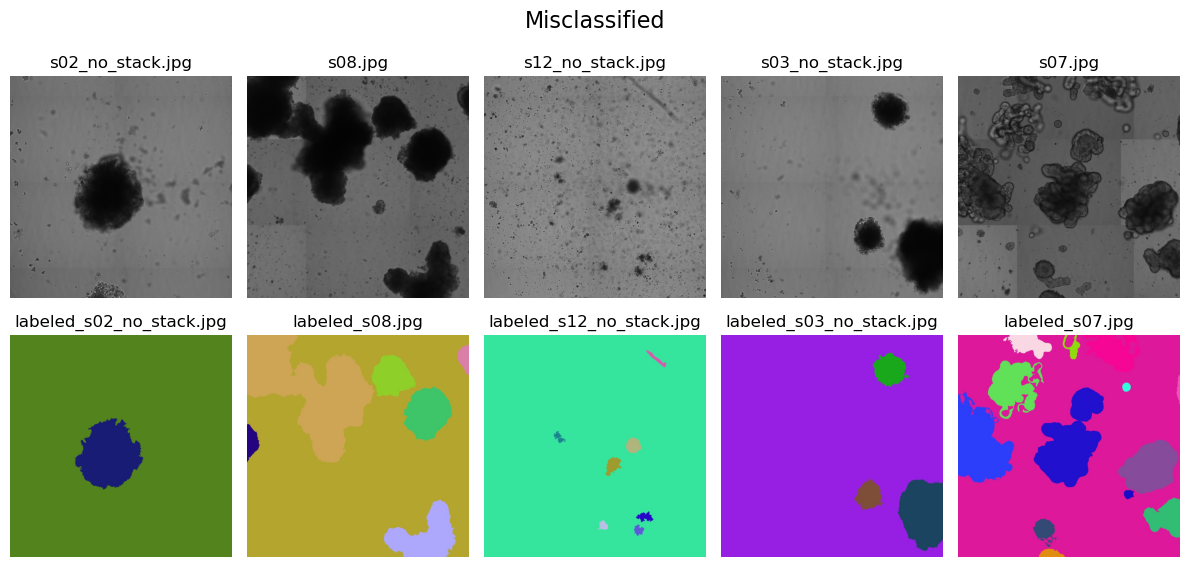

Misclassified Samples (Random State: 25):
2     dead - s02_no_stack.jpg
6              dead - s08.jpg
12    dead - s12_no_stack.jpg
16    dead - s03_no_stack.jpg
23            keep2 - s07.jpg
dtype: object


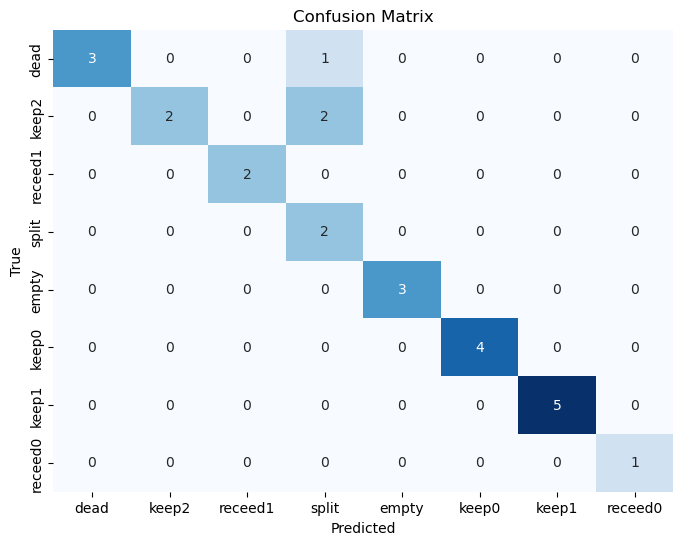

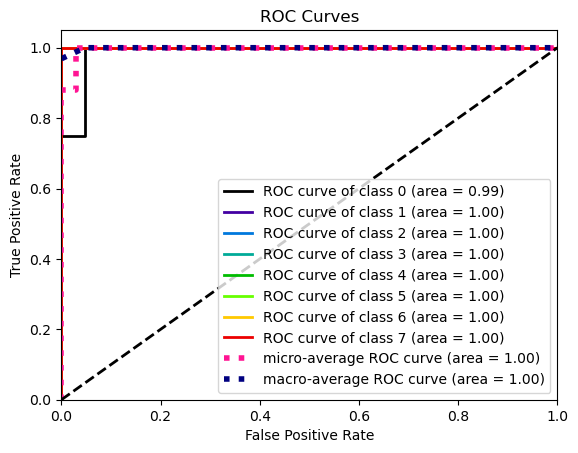

<Figure size 800x600 with 0 Axes>

[[5]
 [5]
 [6]
 [5]
 [1]
 [0]
 [3]
 [6]
 [3]
 [4]
 [3]
 [4]
 [2]
 [2]
 [3]
 [4]
 [6]
 [0]
 [3]
 [6]
 [6]
 [5]
 [1]
 [0]
 [7]]
Successfully loaded data from D:/data_for_seg/


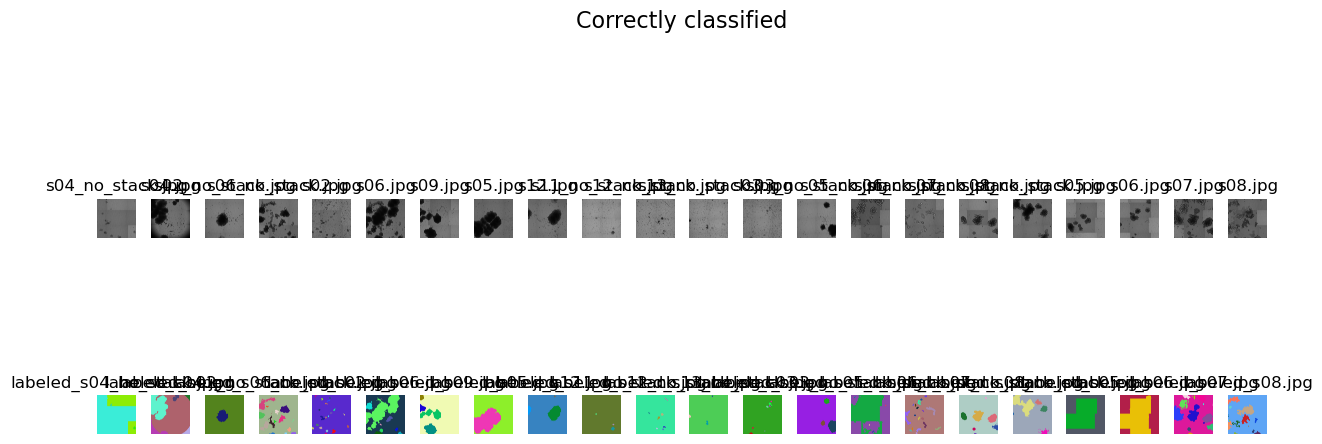

Successfully loaded data from D:/data_for_seg/


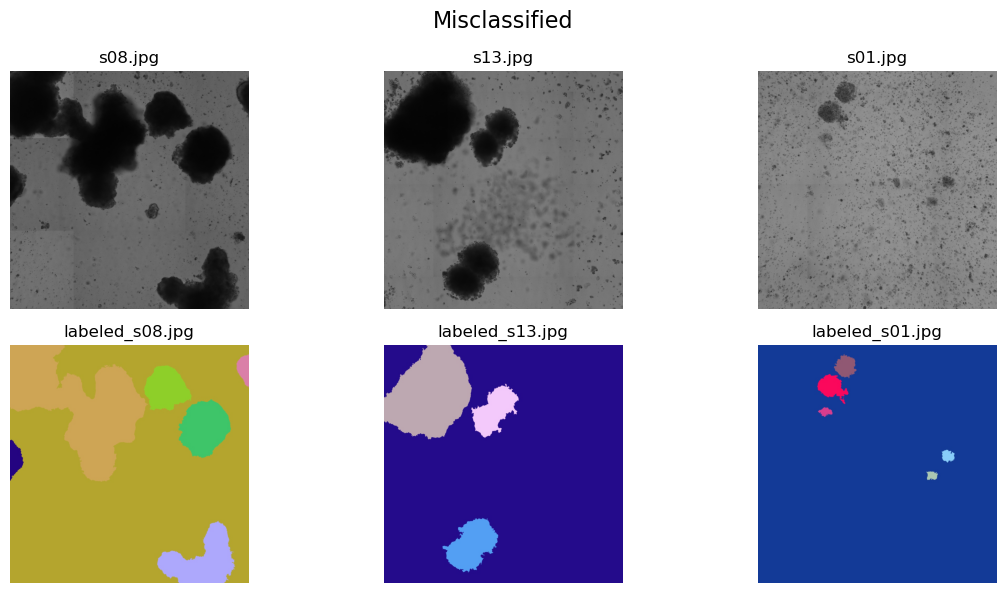

Misclassified Samples (Random State: 40):
6     dead - s08.jpg
10    dead - s13.jpg
14    dead - s01.jpg
dtype: object


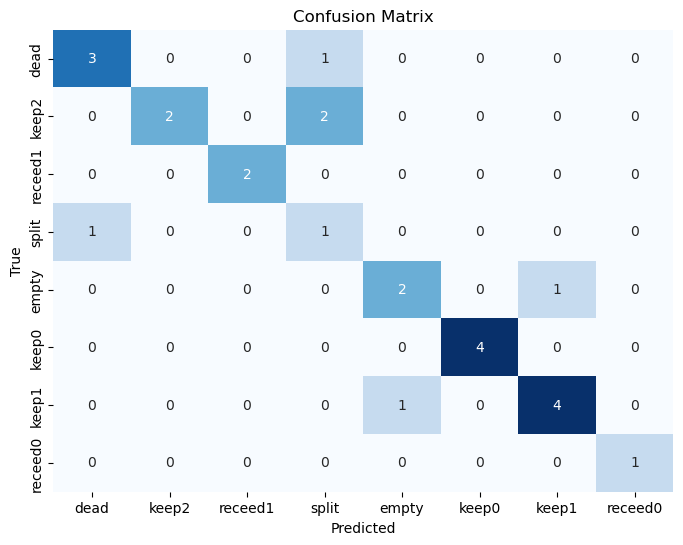

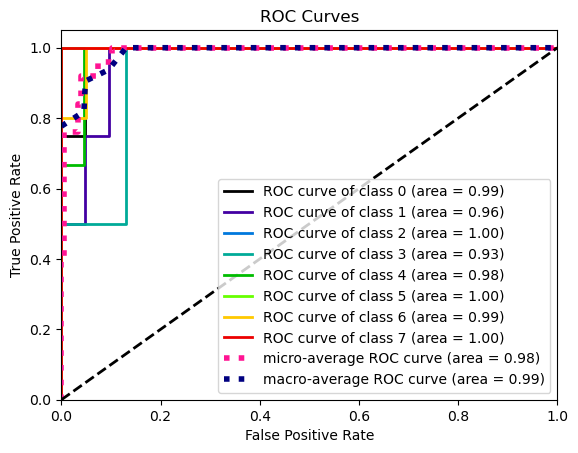

<Figure size 800x600 with 0 Axes>

[[5]
 [4]
 [6]
 [6]
 [5]
 [6]
 [0]
 [3]
 [2]
 [7]
 [3]
 [1]
 [4]
 [4]
 [3]
 [1]
 [5]
 [2]
 [0]
 [3]
 [5]
 [0]
 [0]
 [6]
 [6]]
Successfully loaded data from D:/data_for_seg/


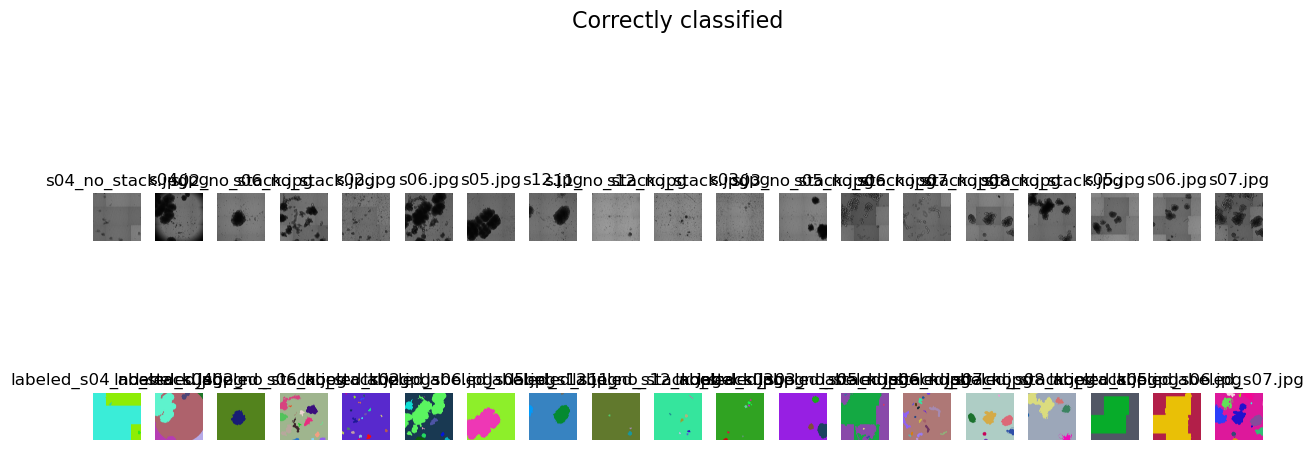

Successfully loaded data from D:/data_for_seg/


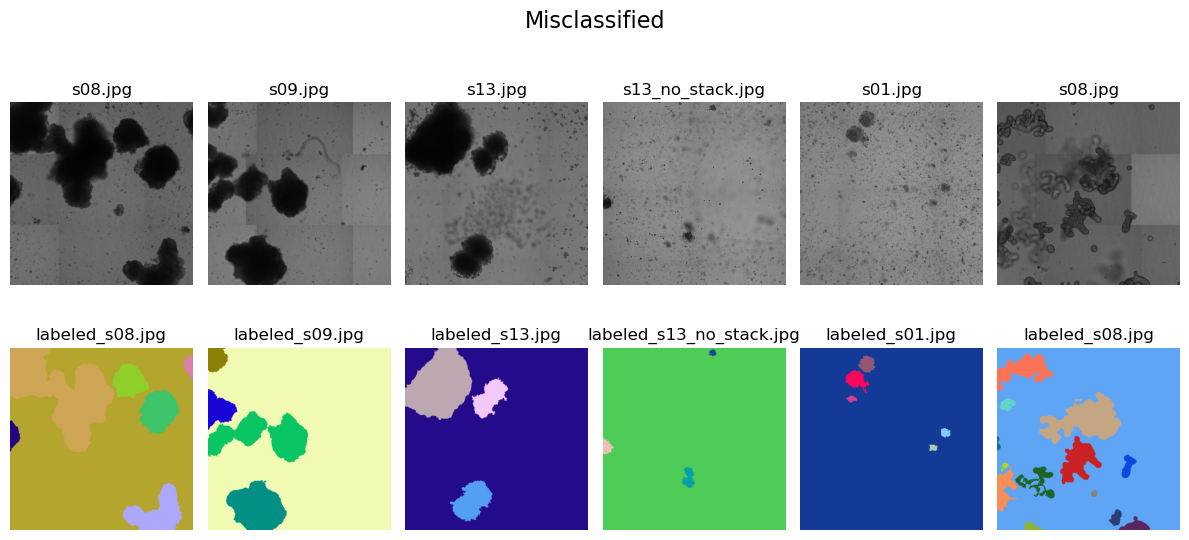

Misclassified Samples (Random State: 78):
6              dead - s08.jpg
7              dead - s09.jpg
10             dead - s13.jpg
13    dead - s13_no_stack.jpg
14             dead - s01.jpg
24            keep2 - s08.jpg
dtype: object


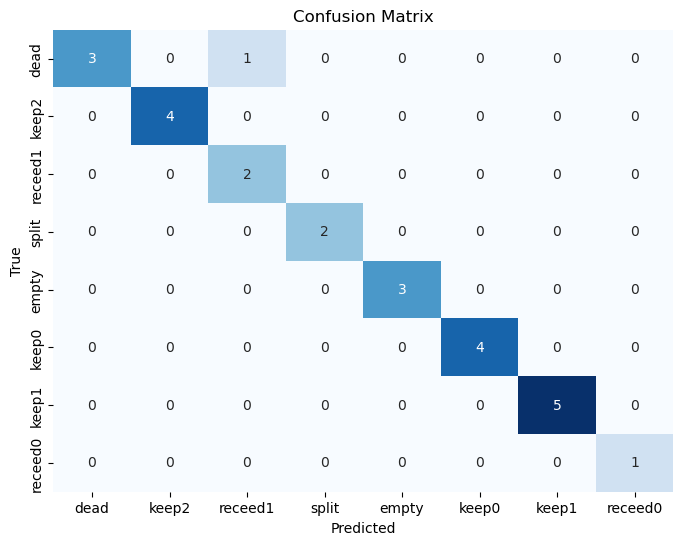

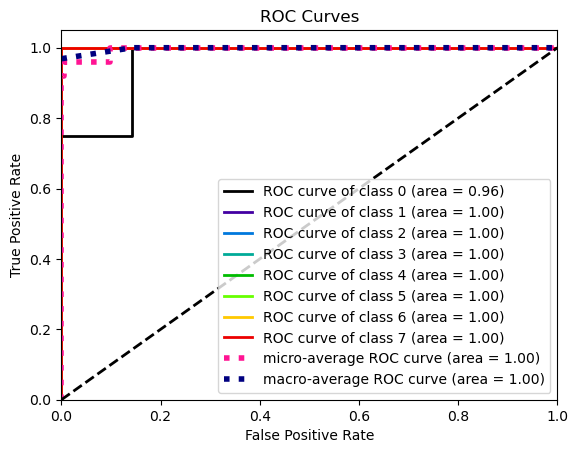

<Figure size 800x600 with 0 Axes>

[[6]
 [3]
 [4]
 [2]
 [1]
 [0]
 [4]
 [6]
 [1]
 [1]
 [6]
 [5]
 [2]
 [1]
 [5]
 [4]
 [5]
 [2]
 [6]
 [5]
 [0]
 [0]
 [3]
 [6]
 [7]]
Successfully loaded data from D:/data_for_seg/


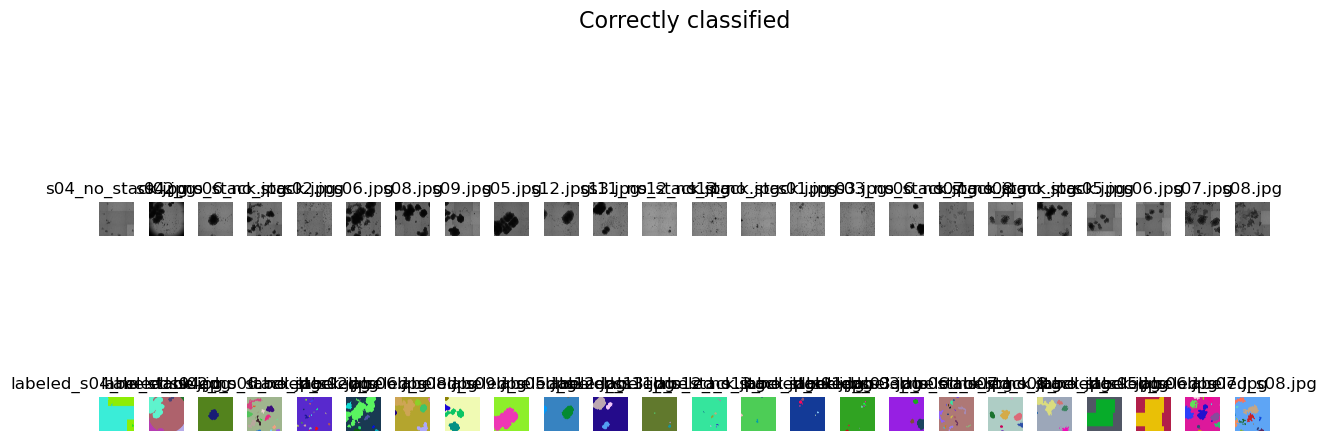

Successfully loaded data from D:/data_for_seg/


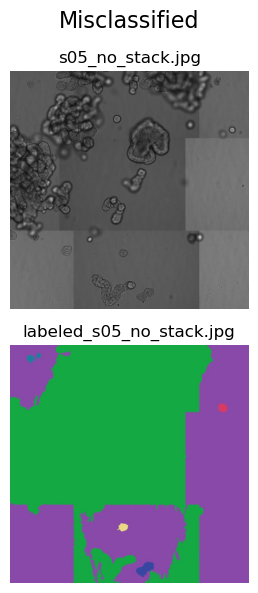

Misclassified Samples (Random State: 90):
17    keep2 - s05_no_stack.jpg
dtype: object


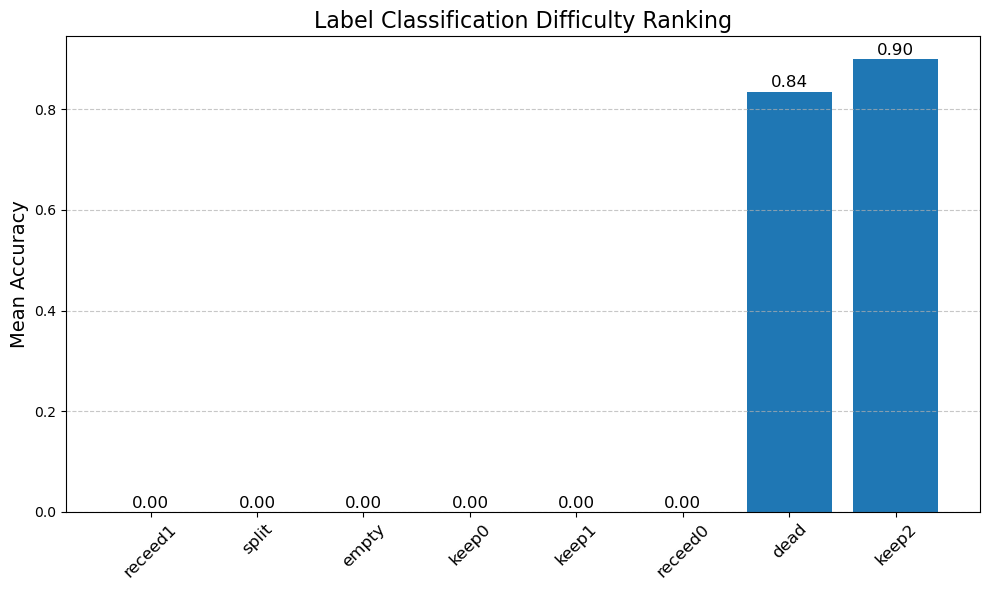

In [26]:
# Import necessary libraries
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight
import scikitplot as skplt

# Load data from a CSV file
data = pd.read_csv(get_hard_disk_path() + "statistics_features_test.csv")
# Assuming the last column is the label and the rest are features
X = data.iloc[:, 2:]
y = data.iloc[:, 1]
# Use a list for labels to ensure consistent order
unique_labels = []
seen = set()

for item in y.values:
    if item not in seen:
        unique_labels.append(item)
        seen.add(item)
        
# Extract unique labels and create a mapping from labels to integers
unique_labels = y.unique()
label_mapping = {label: i for i, label in enumerate(unique_labels)}

# Create a new Series for y with custom labels and the original indexes
y = y.map(label_mapping)

label_metrics = {}  # Dictionary to store label-wise metrics

# Specify different random states
random_states = [30, 25, 40, 78, 90]  # Add more random states if needed

for random_state in random_states:
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)
    y_test = y_test.reset_index(drop=True)
    # Calculate class weights to account for imbalance
    class_weights = len(y) / (len(unique_labels) * np.bincount(y))

    # Initialize the XGBoost classifier for multiclass classification
    classifier = CatBoostClassifier(iterations=1000, bootstrap_type="Bernoulli", verbose=False, **study.best_params)

    # Train the model on the entire training set
    sample_weights = compute_sample_weight(
        class_weight='balanced',
        y=y_train  # provide your own target name
    )

    # Fit the GridSearchCV instance on the training data
    classifier.fit(X_train, y_train, verbose=False, sample_weight=sample_weights)

    # Make predictions on the test set
    y_pred = classifier.predict(X_test)

    conf_matrix = confusion_matrix(y_test, y_pred)

    # Create a heatmap for the confusion matrix with custom labels
    plt.figure(figsize=(8, 6))
    # Specify your custom labels for both rows and columns
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=unique_labels, yticklabels=unique_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate ROC curve and AUC
    y_prob = classifier.predict_proba(X_test)
    # Your code was missing the plot for ROC curve
    skplt.metrics.plot_roc(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')

    # Create ROC curve plot
    plt.figure(figsize=(8, 6))
    plt.show()

    # Retrieve the names of the misclassified samples
    wellclassified_indices = np.where(y_test == y_pred.squeeze())[0]
    wellclassified_samples = data.iloc[y_test.index[wellclassified_indices], 1] + ' - ' + data.iloc[y_test.index[wellclassified_indices], 0]
    show_samples(get_hard_disk_path(), samples=wellclassified_samples, title="Correctly classified")

    misclassified_indices = np.where(y_test != y_pred.squeeze())[0]
    misclassified_samples = data.iloc[y_test.index[misclassified_indices], 1] + ' - ' + data.iloc[y_test.index[misclassified_indices], 0]
    show_samples(get_hard_disk_path(), samples=misclassified_samples, title="Misclassified")

    # Print the names of misclassified samples
    print("Misclassified Samples (Random State: {}):".format(random_state))
    print(misclassified_samples)
    
    misclassified_labels = {}
    wellclassified_labels = {}
    for sample in data.iloc[y_test.index[misclassified_indices], 1]:
        if sample in misclassified_labels:
            misclassified_labels[sample] += 1
        else:
            misclassified_labels[sample] = 1

    for sample in data.iloc[y_test.index[wellclassified_indices], 1]:
        if sample in wellclassified_labels:
            wellclassified_labels[sample] += 1
        else:
            wellclassified_labels[sample] = 1

    labels_accuracy = {}
    for label in unique_labels:
        wellclassified_count = wellclassified_labels.get(label, 0)
        misclassified_count = misclassified_labels.get(label, 0)

        if wellclassified_count + misclassified_count > 0:
            accuracy = wellclassified_count / (wellclassified_count + misclassified_count)
            labels_accuracy[label] = accuracy
        else:
            # Handle the case where there are no samples for a label
            labels_accuracy[label] = 0.0
    
    # Store label-wise metrics for this run
    label_metrics[random_state] = labels_accuracy
    
# Calculate the mean accuracy for each label across runs
mean_accuracies = {label: np.mean([metrics[label] for metrics in label_metrics.values()]) for label in unique_labels}

# Rank labels from easiest to hardest
ranked_labels = sorted(mean_accuracies, key=mean_accuracies.get)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create the bar chart
bars = ax.bar(range(len(ranked_labels)), [mean_accuracies[label] for label in ranked_labels])

# Set x-axis labels
ax.set_xticks(range(len(ranked_labels)))
ax.set_xticklabels(ranked_labels, rotation=45, fontsize=12)

# Set y-axis label
ax.set_ylabel('Mean Accuracy', fontsize=14)

# Set title and adjust title size
ax.set_title('Label Classification Difficulty Ranking', fontsize=16)

# Customize the grid lines
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels on top of the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()